In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('트레인데이터_정규화.csv')

### 트레인 테스트 나누기

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
feature = df.iloc[:,:-1].to_numpy()
target = df.iloc[:,-1].to_numpy()
feature.shape, target.shape

((6480, 26), (6480,))

In [5]:
trainX, testX, trainy, testy = train_test_split(feature, target,random_state=12,
                                               train_size=0.75, stratify=target)

In [6]:
trainX.shape, trainy.shape , testX.shape, testy.shape

((4860, 26), (4860,), (1620, 26), (1620,))

### 주성분 분석

In [7]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [8]:
# PCA를 사용하여 데이터를 차원 축소합니다.
pca = PCA(n_components=7)  
pca.fit(trainX)
pca.explained_variance_ratio_

array([0.63927739, 0.09648029, 0.07219958, 0.03710568, 0.03447714,
       0.02491683, 0.02056805])

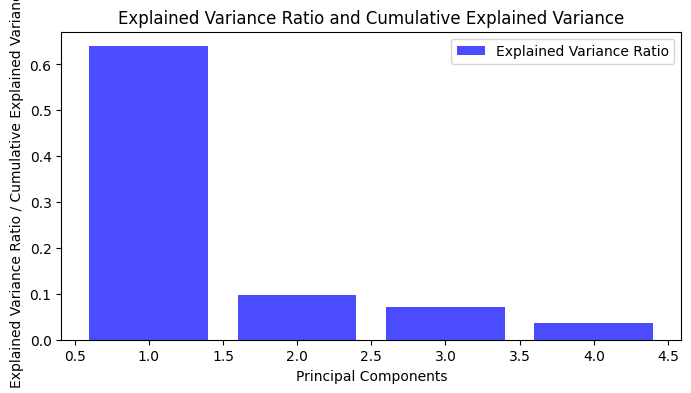

In [11]:
# 주성분 분석 결과에서 설명된 분산량 추출
pca = PCA(n_components=4)  
pca.fit(trainX)
explained_variance_ratio = pca.explained_variance_ratio_

# 설명된 분산량 및 누적 설명된 분산량 그래프 그리기
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align='center', label='Explained Variance Ratio', color='b')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio / Cumulative Explained Variance')
plt.title('Explained Variance Ratio and Cumulative Explained Variance')
plt.legend()
plt.show()

주성분이 4개일 때 누적 설명 분산이 80% 이상이므로 주성분 4개로 분석을 진행한다.

In [16]:
pca = PCA(n_components=4)  
pca.fit(trainX)
trainX_pca = pca.transform(trainX)
testX_pca = pca.transform(testX)

In [17]:
logistic_regression = LogisticRegression()
logistic_regression.fit(trainX_pca, trainy)

LogisticRegression()

In [18]:
logistic_regression.score(trainX_pca, trainy)

0.8411522633744856

In [19]:
logistic_regression.score(testX_pca, testy)

0.8617283950617284

In [20]:
from sklearn.svm import SVC 
SVC_model = SVC(probability=True)
SVC_model.fit(trainX_pca, trainy)

SVC(probability=True)

In [21]:
SVC_model.score(trainX_pca, trainy)

0.8467078189300411

In [22]:
SVC_model.score(testX_pca, testy)

0.8641975308641975

In [23]:
SVC_model.predict(trainX_pca)

array([1., 1., 1., ..., 0., 1., 0.])

In [24]:
SVC_model.predict_proba(trainX_pca)

array([[0.10136161, 0.89863839],
       [0.15754935, 0.84245065],
       [0.04387611, 0.95612389],
       ...,
       [0.94442433, 0.05557567],
       [0.03399709, 0.96600291],
       [0.8652523 , 0.1347477 ]])

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(trainX, trainy)

RandomForestRegressor()

In [26]:
rf.score(testX,testy)

0.8829486419753086

In [27]:
rf.score(trainX,trainy)

0.9829492181069959

In [28]:
print(f'로지스틱  트레인 점수 : {logistic_regression.score(trainX_pca, trainy)}   테스트 점수 : {logistic_regression.score(testX_pca, testy)}')
print(f'SVM 트레인  점수 : {SVC_model.score(trainX_pca, trainy)}   테스트 점수 : {SVC_model.score(testX_pca, testy)}')
print(f'랜덤포레스트  트레인 점수 : {rf.score(trainX,trainy)}   테스트 점수 : {rf.score(testX,testy)}')

로지스틱  트레인 점수 : 0.8411522633744856   테스트 점수 : 0.8617283950617284
SVM 트레인  점수 : 0.8467078189300411   테스트 점수 : 0.8641975308641975
랜덤포레스트  트레인 점수 : 0.9829492181069959   테스트 점수 : 0.8829486419753086


### 로지스틱 모형 선택 , 과적합아니고 성능이 좋고 복잡하지 않음

In [65]:
from sklearn.metrics import classification_report
print(classification_report(testy, model1.predict(testX_pca)))

              precision    recall  f1-score   support

         0.0       0.91      0.81      0.85       810
         1.0       0.83      0.92      0.87       810

    accuracy                           0.86      1620
   macro avg       0.87      0.86      0.86      1620
weighted avg       0.87      0.86      0.86      1620



In [71]:
from sklearn.pipeline import Pipeline
# 주성분
pca = PCA(n_components=4)
# 로지스틱 회귀 모델을 생성합니다.
logistic_regression = LogisticRegression()

# PCA와 로지스틱 회귀를 연결하는 파이프라인을 만듭니다.
pipeline = Pipeline([
    ('pca', pca),
    ('logistic', logistic_regression)
])

# 파이프라인을 학습시킵니다.
pipeline.fit(trainX, trainy)

Pipeline(steps=[('pca', PCA(n_components=4)),
                ('logistic', LogisticRegression())])

In [72]:
# 학습된 모델을 사용하여 예측을 수행합니다.
predicted_probabilities = logistic_regression.predict_proba(trainX_pca)[:, 1].round(2)
predicted_probabilities

array([0.92, 0.76, 0.94, ..., 0.  , 0.89, 0.  ])

In [73]:
import joblib
joblib.dump(pipeline, 'pca_logistic.pkl')

['pca_logistic.pkl']

### 최적화해봤는데 그냥 적합한거랑 별 차이 없음

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [51]:
pipeline = Pipeline([
    ('pca', pca),
    ('logistic', logistic_regression)
])
# 파라미터 그리드 설정
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'logistic__penalty': ['l1', 'l2','elasticnet']      
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(trainX, trainy)

# 최적 파라미터 확인
best_params = grid_search.best_params_
print("최적 파라미터:", best_params)

최적 파라미터: {'logistic__C': 1, 'logistic__penalty': 'l2'}


C:\Users\LG\anaconda3\envs\my_python2\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LG\anaconda3\envs\my_python2\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LG\anaconda3\envs\my_python2\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\LG\anaconda3\envs\my_python2\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.f

In [52]:
# 최적 파라미터로 모델 초기화
best_model = Pipeline([
    ('pca', PCA(n_components=4)),
    ('logistic', LogisticRegression(C=best_params['logistic__C'],penalty=best_params['logistic__penalty']))
])

# 최적 모델 학습
best_model.fit(trainX, trainy)

Pipeline(steps=[('pca', PCA(n_components=4)),
                ('logistic', LogisticRegression(C=1))])

In [53]:
# 최적화 전이 성능이 더 좋음
best_model.score(trainX, trainy), best_model.score(testX, testy)

(0.8411522633744856, 0.8617283950617284)

### 예측

In [3]:
team23_ = pd.read_csv('23시즌롤드컵참가팀.csv')
team23 = team23_.copy()

In [4]:
team23['Region'].fillna('NA', inplace=True)
team23['Win rate'] = team23['Win rate'].str.replace('%',"").astype(float)
team23['Game duration'] = team23['Game duration'].apply(lambda x: x.split(':')[0])
team23['Game duration'] = team23['Game duration'].astype(int)
team23.replace('-', np.nan,inplace=True)
team23 = team23.fillna(value=team23.median(axis=0), axis=0)
team23 = team23.iloc[:,4:]
team23 = team23.astype(float)

C:\Users\LG\AppData\Local\Temp\ipykernel_5528\1184068917.py:6: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  team23 = team23.fillna(value=team23.median(axis=0), axis=0)


In [5]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(team23)

In [6]:
import joblib
model1 = joblib.load('pca_logistic.pkl')
pred_ =  model1.predict_proba(scaled_data)[:,1].round(2)
pred_

array([0.77, 0.68, 0.96, 0.98, 0.97, 0.37, 0.54, 0.35, 0.88, 0.17, 0.01,
       0.46, 0.77, 0.02, 0.27, 0.58])

### 최종데이터 만들기

In [7]:
teamDF = pd.DataFrame(scaled_data)
teamDF.columns = team23_.columns[4:]
baedang = [10, 8, 5, 13, 2.25, 501, 7, 13, 15, 26, 67,301, 81,51, 201,  101]
teamDF['baedang'] = baedang
teamDF['result'] = pred_
teamDF['Name'] = team23_.Name
teamDF

,Win rate,K:D,GPM,GDM,Game duration,Kills / game,Deaths / game,Towers killed,Towers lost,FB%,...,NASHPG,NASH%,CSM,DPM,WPM,VWPM,WCPM,baedang,result,Name
0,0.100200,-0.169492,0.494382,0.232558,0.0,0.765432,0.408602,0.2,-0.230769,0.814371,...,0.461538,-0.016484,-0.115385,0.058347,1.75,0.111111,0.520548,10.00,0.77,Bilibili Gaming
1,-0.180361,-0.576271,-0.029963,-0.098191,0.0,-0.716049,-0.150538,0.0,-0.076923,-0.251497,...,0.615385,0.203297,0.346154,-0.745543,0.75,0.592593,0.027397,8.00,0.68,T1
2,0.717435,0.779661,0.689139,0.914729,0.0,-0.024691,-1.096774,1.0,-0.307692,1.149701,...,0.461538,0.412088,1.269231,-0.719611,-0.25,-0.111111,1.397260,5.00,0.96,Gen.G eSports
3,0.533066,0.881356,0.119850,0.263566,0.0,-0.567901,-1.483871,0.4,-0.230769,0.407186,...,-0.615385,0.390110,1.115385,-2.003241,0.25,0.444444,0.410959,13.00,0.98,KT Rolster
4,1.190381,1.084746,1.198502,1.266150,-2.0,0.814815,-0.881720,1.4,-0.769231,0.119760,...,-0.307692,0.664835,0.807692,0.654781,0.25,-0.111111,0.630137,2.25,0.97,JD Gaming
5,0.653307,0.169492,1.123596,0.563307,-1.0,1.308642,0.408602,1.0,-0.153846,-0.814371,...,-0.461538,0.291209,0.576923,0.408428,-0.25,0.481481,-0.465753,501.00,0.37,GAM Esports
6,0.204409,0.440678,0.029963,0.087855,0.0,0.419753,-0.494624,0.0,0.230769,0.970060,...,-0.153846,0.016484,-0.115385,-0.116694,0.00,0.000000,0.000000,7.00,0.54,LNG Esports
7,-0.100200,-0.237288,-0.134831,-0.087855,-1.0,-0.320988,-0.279570,-0.4,0.153846,-0.994012,...,-0.461538,-0.291209,-0.115385,-1.011345,0.00,0.000000,0.000000,13.00,0.35,Weibo Gaming
8,-0.140281,0.372881,-0.479401,-0.253230,0.0,-0.864198,-1.225806,-1.2,0.076923,0.862275,...,-0.615385,-0.302198,0.576923,-0.602917,1.25,1.074074,0.246575,15.00,0.88,Dplus KIA
9,0.685371,0.474576,1.288390,0.945736,-2.0,1.753086,0.322581,1.2,-0.307692,-0.526946,...,0.461538,0.532967,-0.730769,0.667747,-0.25,-1.074074,-1.342466,26.00,0.17,G2 Esports


In [8]:
meta = pd.read_csv('팀별메타챔사용횟수.csv')
meta.rename({'team':'Name'},axis=1, inplace=True)
teamStat = pd.read_csv('팀능력_전처리.csv')
teamStat.rename({'team':'Name'}, axis=1, inplace=True)

In [9]:
teamDF=teamDF.merge(meta, on='Name')
teamDF=teamDF.merge(teamStat, on='Name')
teamDF.set_index('Name', inplace=True)


In [10]:
teamDF.to_csv('23시즌롤드컵_최종데이터.csv', encoding='utf-8')